# Datacamp: Michelin restaurant classification
Authors: *Quentin Garsault, Charles Cuvillier, Lucas Selini, Eric Patarin*

<img src="./img/logo%20michelin.jpg" alt="Logo michelin" width="300">



## Table of Contents
* [Introduction](#introduction)
* [The dataset](#dataset)
* [Requirements](#requirements)
* [Data exploration](#exploration)
* [Base model](#base_model)

## Introduction <a class="anchor" id="introduction"></a>

In the world of gastronomy, Michelin stars serve as markers of exceptional culinary achievement, indicating not just the quality of food but also the overall dining experience. 

Restaurants are evaluated based on various criteria, including the quality of ingredients, skillful preparation, creativity, and overall dining ambiance. The Michelin Guide meticulously assesses these factors to award restaurants with one, two, or three Michelin stars, signifying varying degrees of excellence.

Our data challenge revolves around predicting the Michelin star rating for restaurants using a dataset that includes culinary and contextual information. By analyzing the features associated with Michelin-starred establishments, we aim to unravel the intricate patterns that contribute to the prestigious recognition. Our challenge seeks to enhance the understanding of the culinary world and provide insights into the factors that elevate a restaurant to Michelin-star status.

## The dataset <a class="anchor" id="dataset"></a>

For this challenge, the data were first preprocessed and then split in order to preserve a private test set on which to evaluate the models on the servers. This leaves 2653 observations in the public train set and 639 observations in the public test set. 

Preprocessing steps before splitting the data:


Glossary of the terms used in the dataset:

## Requirements <a class="anchor" id="requirements"></a>

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer

# workflow libraires
from sklearn.base import is_classifier
from sklearn.utils import _safe_indexing
# from ..utils.importing import import_module_from_source

import rampwf as rw

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9524\2480767625.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Download Data

In [3]:
#execute the downlaad_data.py file to get the data. You have to enter your Kaagle username and key. 

# Not executed here because impossible to write your username and key in a notebook

## Data Exploration <a class="anchor" id="exploration"></a>

In [5]:
train_df=pd.read_csv('./data/train.csv')
columns=['name','blurb','city','country','lat','lon','chef','cuisine1','cuisine2']
X_train_df=train_df[columns]
X_train_df.head()

,name,blurb,city,country,lat,lon,chef,cuisine1,cuisine2
0,Malathounis,"Run by a friendly husband and wife team, Malth...",Kernen im Remstal,Germany,48.793824,9.342388,Joannis Malathounis,Mediterranean Cuisine,Greek
1,Solana,Located next to the Santuario de la Bien Apare...,Ampuero,Spain,43.326314,-3.453151,Ignacio Solana Pérez,Modern Cuisine,NaN
2,Poemas by Hermanos Padrón,A unique culinary experience overseen by the a...,Las Palmas de Gran Canaria,Spain,28.121197,-15.427277,Iciar Pérez,Creative,NaN
3,Schote,"In Essen's city centre, Nelson Müller proposes...",Essen,Germany,51.437828,7.005291,Nelson Müller,Modern Cuisine,Market Cuisine
4,Seventh Son,The Hong Kong based chain opened this comforta...,Shanghai,China Mainland,31.219598,121.460072,NaN,Cantonese,NaN


<Axes: >

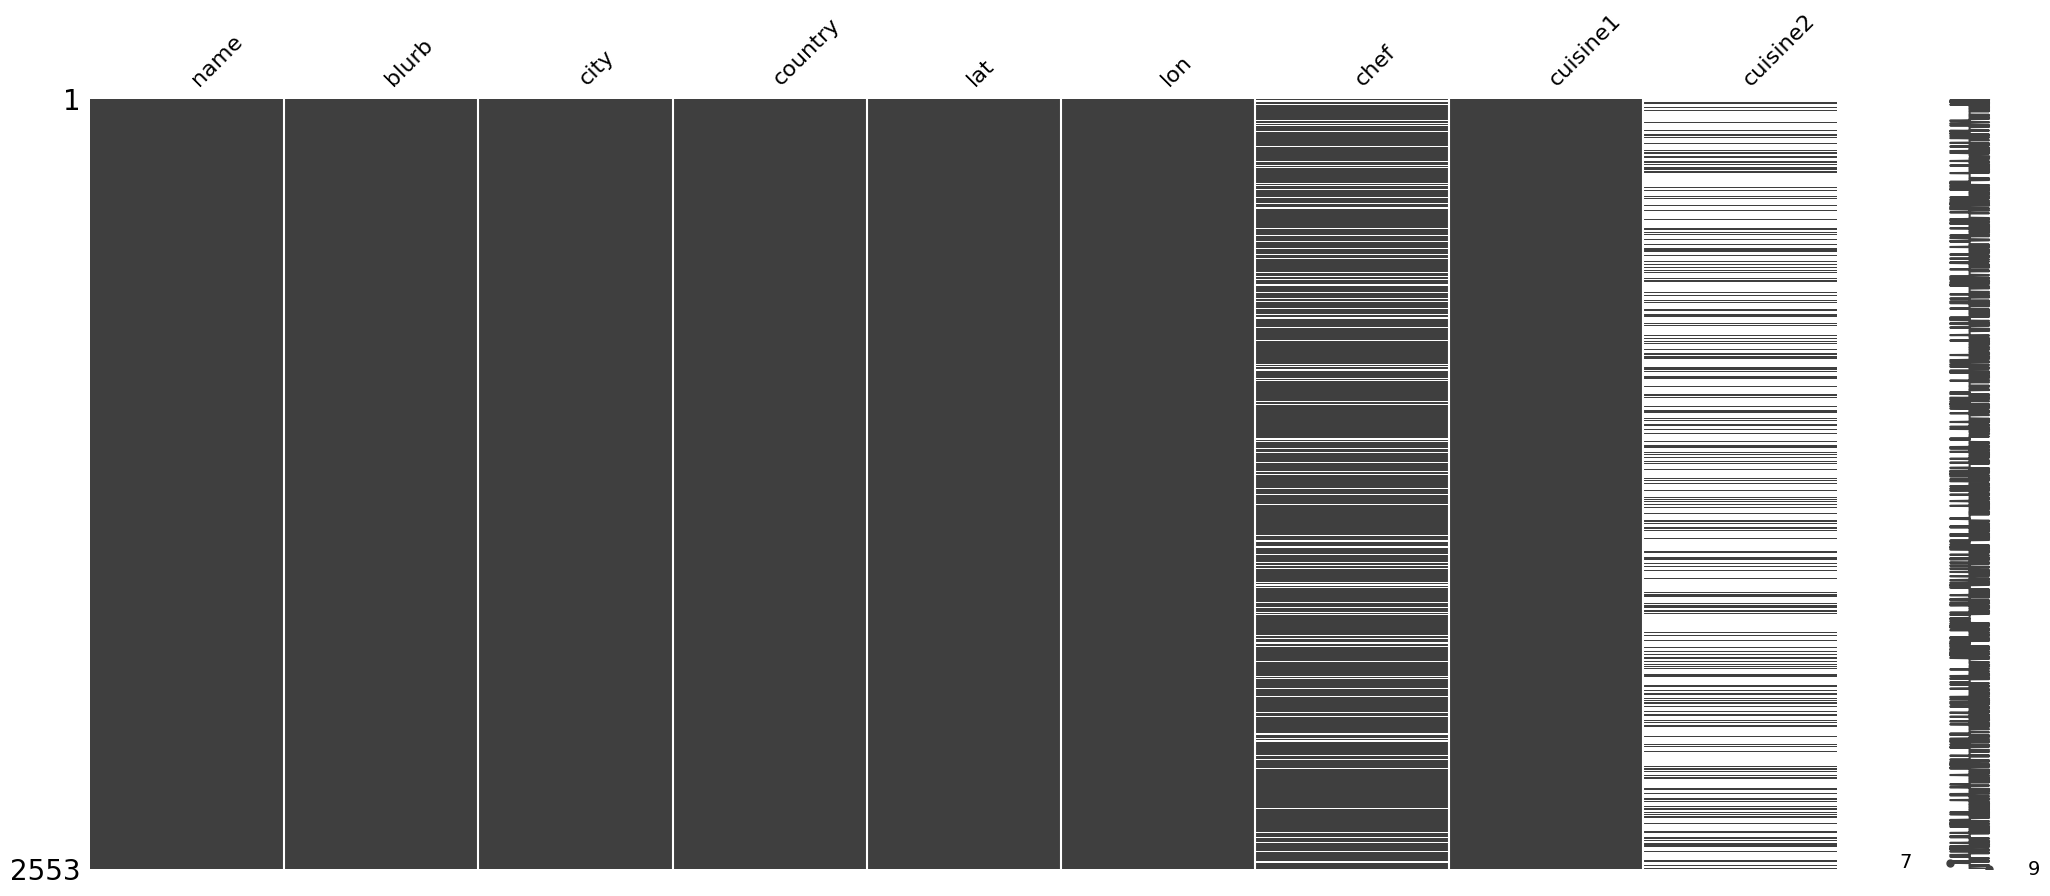

In [6]:
msno.matrix(X_train_df)

In [8]:
test_df=pd.read_csv('./data/test.csv')
columns=['name','blurb','city','country','lat','lon','chef','cuisine1','cuisine2']
X_test_df=test_df[columns]
X_test_df.head()

,name,blurb,city,country,lat,lon,chef,cuisine1,cuisine2
0,House of Tides,This characterful Grade I listed merchant’s ho...,Newcastle Upon Tyne,United Kingdom,54.967968,-1.610114,Kenny Atkinson,Modern Cuisine,NaN
1,Hjem,The setting in an English country inn might se...,Wall,United Kingdom,55.014238,-2.132913,Alex Nietosvuori,Scandinavian,NaN
2,Fat Duck,This iconic restaurant celebrated its 25-year ...,Bray,United Kingdom,51.507858,-0.701753,Edward Cooke,Creative,NaN
3,Campton Place,The breadth and complexity of Indian cuisine g...,San Francisco,United States,37.789230,-122.406650,Srijith (Sri) Gopinathan,Indian,Contemporary
4,Imperial Treasure Fine Chinese Cuisine (Huangpu),This restaurant from the Singaporean group is ...,Shanghai,China Mainland,31.223180,121.464502,NaN,Cantonese,NaN


<Axes: >

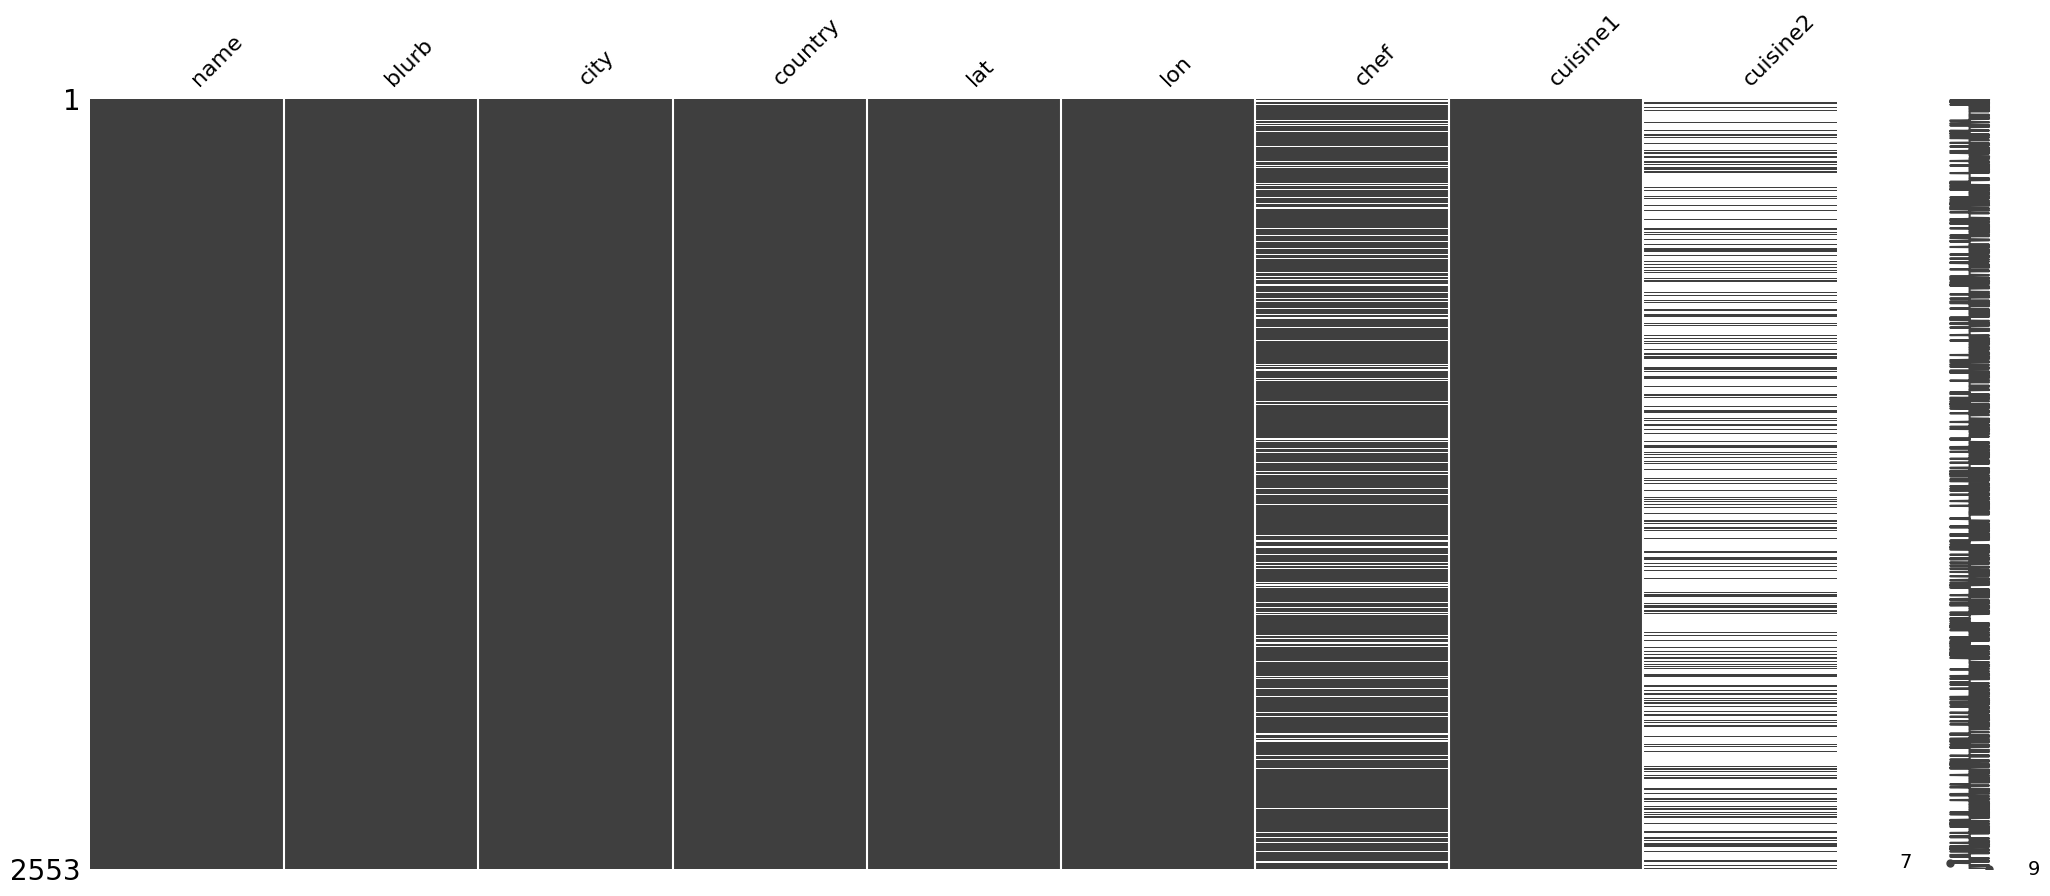

In [9]:
msno.matrix(X_train_df)

In [10]:
problem_title = "Classification de restaurant au guide Michelin"

# Correspondence between categories and int8 categories
# Mapping int to categories
int_to_cat = {
   1 : 'ONE_STAR',
   2 : 'TWO_STARS',
   3 : 'THREE_STARS',
}

_event_label_int = list(int_to_cat)

Predictions = rw.prediction_types.make_multiclass(label_names=_event_label_int)
workflow = rw.workflows.Classifier()

# Mapping categories to int
cat_to_int = {v: k for k, v in int_to_cat.items()}

score_types = [
    rw.score_types.BalancedAccuracy(
        name="bal_acc", precision=3, adjusted=False
    ),
    rw.score_types.Accuracy(name="acc", precision=3),
]

def _get_data(path=".", split="train", cat_to_int = cat_to_int):
    # Load data from csv files into pd.DataFrame

    data_df = pd.read_csv(os.path.join(path, "data", split + ".csv"))

    data_df["cuisine1"] = data_df["cuisine1"].astype("category")
    data_df["cuisine2"] = data_df["cuisine2"].astype("category")

    # usefull columns
    subset = [
        'name',
        'blurb',
        'michelin_award',
        'city',
        'country',
        'lat',
        'lon',
        # 'image',
        'chef',
        'cuisine1',
        'cuisine2',
        # 'url',
        # 'url2'
    ]

    X = data_df[subset]

    # labels
    y = np.array(data_df["michelin_award"].map(cat_to_int).fillna(-1).astype("int8"))

    return X, y

groups = None

def get_train_data(path="."):
    data = pd.read_csv(os.path.join(path, "data", "train.csv"))
    data["name"] = data["name"].astype("category")
    Name = np.array(data["name"].cat.codes)
    global groups
    groups = Name
    return _get_data(path, "train")


def get_test_data(path="."):
    return _get_data(path, "test")

def get_cv(X, y):
    cv = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=2)
    return cv.split(X, y, groups)


In [11]:
y_train = np.array(train_df['michelin_award'].map(cat_to_int).astype('int8'))
y_train.shape

(2553,)

In [12]:
y_test = np.array(test_df['michelin_award'].map(cat_to_int).astype('int8'))
y_test.shape

(639,)

In [13]:
text=['blurb']
cat_column=['name','city','country','chef','cuisine1','cuisine2']
num_column=['lat','lon']

## Base model <a class="anchor" id="base_model"></a>

In [ ]:
# %% define classification model

X_train_df, y_train = get_train_data()
X_test_df, y_test = get_test_data()

# The model will take numpy arrays as input.
X_train = X_train_df.to_numpy()

X_test = X_test_df.to_numpy()


numeric_transformer = Pipeline(
    steps = [
        ("imputer", SimpleImputer(strategy="constant", fill_value="")),  
        ("vectorizer", TfidfVectorizer()),  # Convert text to numbers
        ("scaler", StandardScaler())  
])

clf_lr = Pipeline(
    steps=[("transformer", numeric_transformer), ("classifier", LogisticRegression(max_iter=500))]
)

clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)


print("balanced accuracy score linear regressor (score to beat) = ", balanced_accuracy_score(y_test, y_pred_lr))